In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 4
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [6]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i],i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+4],i)

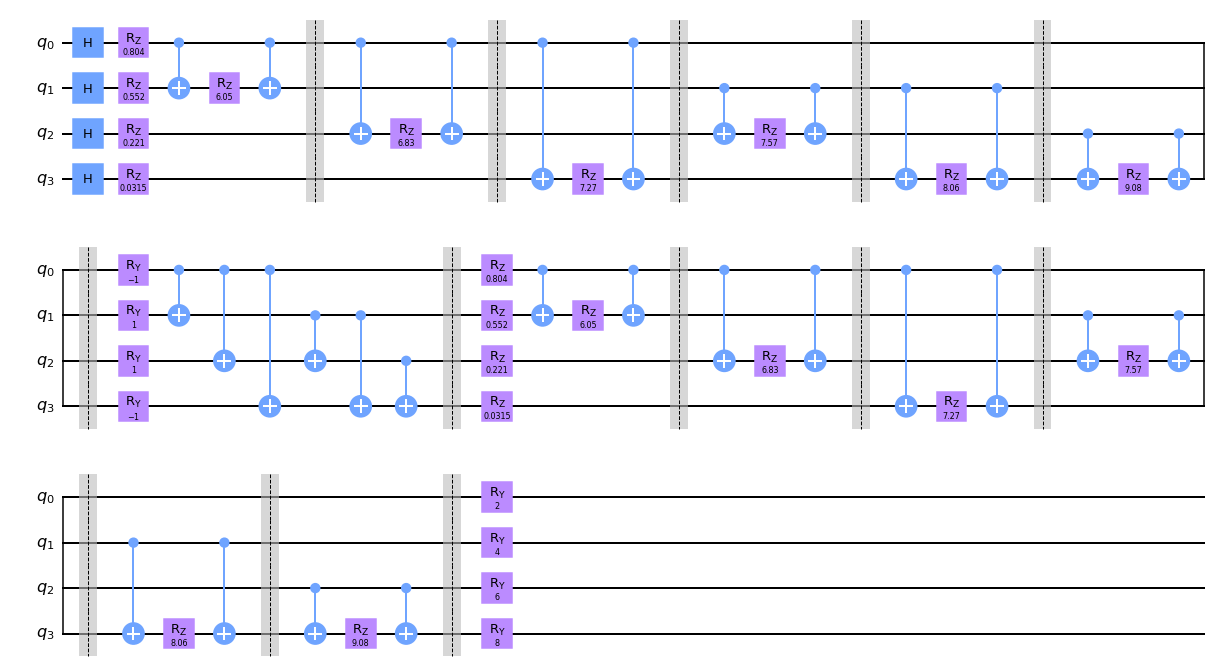

In [7]:
cir = QuantumCircuit(n)
final_circuit(cir, x[0], [-1,1,1,-1,2,4,6,8])
cir.draw('mpl')

In [9]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 8   # num of trainable params
for i in range(100):
    print(i)
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer2Hard4q/quantum_loss_hard_layer2_%d.npy' %i
    f2 = 'Layer2Hard4q/opt_params_hard_layer2_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

0
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546  ]
[0.6112256080606028, 0.5510182900844764, 0.5027640666717063, 0.4589425330102301, 0.4230893834454253, 0.40052818931329215, 0.3925555517957688, 0.39434439482927647, 0.39797958916402654, 0.3977075520174372, 0.39180202244471835, 0.38113161980436283, 0.3675313507032444, 0.3529004879737243, 0.3387464227381909, 0.3259792817856161, 0.3149302171962697, 0.3055090887215017, 0.29733937092324686, 0.2898396309912007, 0.28234118942728936, 0.2742566139067406, 0.2652135429757529, 0.255091586428999, 0.2439867020142403, 0.23216599519624476, 0.22004684832507004, 0.20818062073604723, 0.19719564807636034, 0.1876750510348971, 0.17999456775759623, 0.1741896484038544, 0.16992551047079926, 0.16659883612420195, 0.16353089812976465, 0.1601671814370192, 0.15620492933318994, 0.15161701635049316, 0.1465881186135425, 0.14140593020442802, 0.13635421420276447, 0.1316435892170909, 0.1273943203543565, 0.12365892869289409,

[0.4303484168069451, 0.3728222756945741, 0.32722806691868556, 0.29882121774254505, 0.2906742157026415, 0.29870603296704173, 0.31242869636443105, 0.3219395269561324, 0.32337885845566666, 0.31793134078718255, 0.30815924397496053, 0.296696541786818, 0.2862722986786615, 0.278992668378282, 0.2758455004109157, 0.2765484922899466, 0.2796688403999907, 0.2831681622749855, 0.28531966914698786, 0.2853278053835901, 0.283307064088203, 0.2799467908154951, 0.2761509136262057, 0.27274723373112403, 0.2702949839798651, 0.26900343993017783, 0.2687485978701461, 0.26915356450937994, 0.2697126920450498, 0.269951353251333, 0.26958430599353994, 0.2685998122069071, 0.2672167510532373, 0.2657385823056971, 0.2643987778203623, 0.26329037156003365, 0.26239645040092474, 0.26166080883660153, 0.261028145898164, 0.2604354415747375, 0.2597918075285181, 0.25899511909329714, 0.2579879956583333, 0.25680215310238863, 0.2555460359050394, 0.2543441462674931, 0.2532728055760742, 0.2523322008584179, 0.25146491430340423, 0.2505

[0.7039467849867858, 0.6186696939011848, 0.5676344761884101, 0.5405272474784367, 0.5180249012571942, 0.4912197046636938, 0.4605221316549613, 0.4298249891937931, 0.4027933581024873, 0.381346950490714, 0.36601557165148246, 0.3560561156550795, 0.3494953983596378, 0.34429929447313473, 0.3391346710639433, 0.33344296401626583, 0.32736669737534096, 0.3214046163602147, 0.3158523612119078, 0.3104839358711371, 0.30479417619669436, 0.2985430212751456, 0.2920610599051789, 0.28611869467692747, 0.28153854299089476, 0.27880341229277034, 0.2778533438014316, 0.2781664573064236, 0.2790532480916662, 0.2799574280191259, 0.28059306701542097, 0.2809030725277521, 0.2809327888613432, 0.2807140458716836, 0.28020802206750267, 0.2793144881256494, 0.2779292306294513, 0.276017476266844, 0.27366450059650965, 0.2710728161951058, 0.26850414112072507, 0.26619440998824334, 0.26428207221924616, 0.26278029771618994, 0.2616005856855567, 0.2606116823449498, 0.259701757746928, 0.25881200251949055, 0.25792858770638705, 0.257

[0.6793579583789958, 0.5788168973058211, 0.5097557792214981, 0.4792968506331064, 0.4773692178846735, 0.48282867810095165, 0.48255010841764523, 0.4740373143018512, 0.4601442863280295, 0.4452063612264159, 0.4329010280158543, 0.42518970948289053, 0.4220385498916912, 0.4218451562955458, 0.42236664734040713, 0.42169389971745075, 0.4188264085785547, 0.413718890313455, 0.40698774663088405, 0.39953154005924396, 0.3922074895586749, 0.3856106498165484, 0.3799755208878187, 0.37521166093308816, 0.3710450019316191, 0.36718377456718987, 0.3634240935192309, 0.3596683974514479, 0.35589248565298887, 0.3521127299708989, 0.34837701094463486, 0.34477062864346497, 0.3414140353845478, 0.3384383630862115, 0.33594272849142826, 0.3339518374713405, 0.3323972405019212, 0.3311379458901249, 0.33001595739589734, 0.32891960547886706, 0.3278202154513017, 0.32676273766096725, 0.32581718113945607, 0.32501654675056485, 0.32431139921516317, 0.32356259577362717, 0.32257571541059843, 0.32115825934394476, 0.3191672752300099

[0.5122378481112616, 0.4749493081367649, 0.44473934414454896, 0.42156052573641867, 0.40473788955274814, 0.3946932850323819, 0.39080621758986395, 0.3902474158821965, 0.3897538506387521, 0.38779315633628403, 0.3842638930912483, 0.3797209086588969, 0.37490032370218007, 0.37046160381978294, 0.3667868070617429, 0.364037110265813, 0.3623666198557009, 0.3619084536630249, 0.3625939133722367, 0.36405555004372914, 0.36565895853207514, 0.3666613038028541, 0.36647982337262835, 0.3649215145996145, 0.3622275460252036, 0.3589299978521195, 0.3556260111230662, 0.3527882166212201, 0.35066846871799573, 0.3492752666463775, 0.34838896161810423, 0.34761874027384726, 0.34651909187430635, 0.3447322739841764, 0.34208772798408804, 0.3386347477881991, 0.3346255394568204, 0.33044272899135985, 0.32644095516633137, 0.32273652846090944, 0.3191047660263295, 0.315118963971343, 0.31039954990229224, 0.30476310198768697, 0.2982892293337979, 0.29136368134612567, 0.28461103588533815, 0.27864246032853096, 0.2737444945241453

[0.6911961066782087, 0.5973971924217768, 0.5482089398720591, 0.5240235931912237, 0.5067651517173987, 0.4900737397302024, 0.4735480644708528, 0.4588509150538132, 0.44780430100927643, 0.4408155244664579, 0.4363786932756218, 0.43239598755966613, 0.4276807469822552, 0.4221397791534538, 0.4163225143955494, 0.41099745548816735, 0.40682800282853343, 0.40411212543000774, 0.40262976886788354, 0.4017182012828372, 0.4006036370455092, 0.398770819251969, 0.39610990303830346, 0.3928320345212214, 0.3892959393557333, 0.3858500559717757, 0.38272511688488425, 0.3799841917713297, 0.3775275257055974, 0.3751415049479093, 0.3725703191615907, 0.3695847542297512, 0.3660284005756178, 0.3618356112587385, 0.3570278176662253, 0.35170131529070703, 0.34601732713990374, 0.34019742797314684, 0.3345179604312295, 0.32929286264970914, 0.3248376158424285, 0.32141703182995196, 0.3191889794764415, 0.3181612074303474, 0.3181758586176075, 0.31892885557751227, 0.320023105697997, 0.3210456509524933, 0.32165140451752805, 0.3216

24
[ 0.92003461  0.3990241   0.99973459 -0.5598654  -0.27788729  0.47968198
  0.99291145 -0.36730604]
[0.4449201381127561, 0.39116407771011724, 0.3584140228776733, 0.3429673970008805, 0.3376211135925886, 0.33499449077242954, 0.33012449477206435, 0.32121599289152863, 0.30918286068307665, 0.2960879724488812, 0.28399039046548696, 0.2743052190278269, 0.26767308565722897, 0.2641432218009275, 0.263324267230981, 0.26443631193201, 0.26643682382015266, 0.26831058604324665, 0.2693594950986806, 0.26929683539256855, 0.26816790886582664, 0.26621049220712933, 0.2637204935845537, 0.26094890814114485, 0.25804848670032304, 0.2550828117525096, 0.2520847840588314, 0.24911848451772595, 0.2463000127640364, 0.24377173735680863, 0.24165392497195676, 0.24000193249771304, 0.23878865061557353, 0.23791820216977166, 0.23726117064582483, 0.23669481961959749, 0.23613528381565424, 0.2355522109968457, 0.2349605815761076, 0.234395344231681, 0.2338853391495076, 0.23344124224658142, 0.2330602322355562, 0.232738304382840

[0.7497636442992939, 0.6876362811938146, 0.6246985896647301, 0.5681236798875315, 0.5211691572943286, 0.48389327471789356, 0.4561311763517836, 0.438028245827442, 0.42857218316352835, 0.4251149002249851, 0.42419367040304296, 0.42274091161270916, 0.41896170086104007, 0.41253716484913533, 0.40427535378981566, 0.3955344961835948, 0.3876508411291823, 0.38146806838372116, 0.3770721642926096, 0.3738902459671799, 0.3711523665330203, 0.36838631696338475, 0.3655972392693677, 0.3631005388011621, 0.3612006526636158, 0.35992991821324094, 0.35900632040693164, 0.3580459878899945, 0.35686087829546725, 0.3555900822795746, 0.3545801880084574, 0.35413703359547083, 0.35432363736296707, 0.3549088151882181, 0.355476733626683, 0.35563363812979043, 0.3551938182317362, 0.35422833239912355, 0.35295665263514786, 0.35157546555926755, 0.3501466572135788, 0.3486014287323461, 0.34682360082019376, 0.34473045928770035, 0.34229379648366653, 0.33950175324394416, 0.3363028501923687, 0.3325791747366482, 0.3281684683634139,

[0.6410601382713539, 0.5734609798698712, 0.5274041359756785, 0.5023001349115379, 0.48992139340668617, 0.4799916953037603, 0.4688724584672539, 0.458197426877887, 0.4508315149918146, 0.4483173351768417, 0.449689207525397, 0.4518137485977424, 0.45120482597041706, 0.44571555391484685, 0.4348222045657603, 0.41902321141036125, 0.399359875303467, 0.37737298080617127, 0.35519225469433197, 0.33531469080687115, 0.3199116154766358, 0.30992093002922216, 0.3044700727806871, 0.3011855140187711, 0.2974065316777581, 0.2914365906873265, 0.2829557846807016, 0.27265873049326456, 0.2616726495801337, 0.25107427837203405, 0.24155514487645754, 0.2332684937195457, 0.22594574481751886, 0.21926061002399197, 0.21318191238323628, 0.20800500183437967, 0.2039971205567749, 0.20091565863749117, 0.19785548227940677, 0.19369098954048622, 0.18781057487509412, 0.18054958495095763, 0.17303381416397876, 0.16660202372265412, 0.1621585741067259, 0.1597766900708045, 0.15877384457661614, 0.1582297173612831, 0.15756008144866138

36
[ 0.45701438  0.20322842  0.90436133 -0.7136531   0.61471826 -0.27357081
 -0.62688638 -0.48169752]
[0.7559447048780744, 0.6861139978260614, 0.6258356855132231, 0.581601735826592, 0.5531210137798155, 0.5317320027263256, 0.5120101729912893, 0.4952436583516788, 0.48481240003720766, 0.4816256601632539, 0.4828010651192907, 0.4838229934536727, 0.4817880771549591, 0.4766660733546321, 0.4702579841437756, 0.4644476317787155, 0.4596674019081763, 0.45462172660903927, 0.44761526339997476, 0.43763485786347994, 0.42443493654528597, 0.4083878533485903, 0.3904589233332074, 0.37225019041857865, 0.3558941964344172, 0.34356223430084915, 0.33658338766877566, 0.3346367076722079, 0.33580170715996266, 0.33771021786464783, 0.338808300369005, 0.3386760616613845, 0.33758947903234315, 0.3360061835079492, 0.33425575846287126, 0.3324177395571098, 0.33034508047084205, 0.3277886943702455, 0.32454538900709423, 0.3205428421083465, 0.31582378411261985, 0.3104664571553611, 0.3045253695854823, 0.2980545719327269, 0.29

[0.6578749848630362, 0.6163157801863152, 0.5713197627013432, 0.5268414030203141, 0.49659900916022154, 0.4897600188269161, 0.4998067151603595, 0.5095197292130457, 0.5079568227194298, 0.4941415602951588, 0.47233237649148824, 0.4475195494269146, 0.4231448366320253, 0.4004306565900778, 0.37871624707992263, 0.3566385030613574, 0.3333140446993263, 0.3089177679417502, 0.28475166575834937, 0.2627066625331861, 0.24410901051425488, 0.22867116678020463, 0.21471467643810782, 0.2007469225852301, 0.18674434495126985, 0.17403119717349158, 0.1642841831524613, 0.15852755305243246, 0.15663893322613873, 0.15753682879501513, 0.1597900768305653, 0.1621660841873618, 0.16388794839947443, 0.16467919035416112, 0.16469105111002144, 0.16432202270427135, 0.16397190785664703, 0.16384262472503863, 0.16387628686473843, 0.16383229999005722, 0.163437452240768, 0.16252948777017093, 0.1611300791933768, 0.15941818682890724, 0.15762618437459344, 0.1559276790662408, 0.15438892146553368, 0.153005856375333, 0.151780719183859

44
[ 0.6696843  -0.79040779  0.48928096 -0.27899833 -0.28137832  0.21847676
 -0.2124409  -0.18185478]
[0.6097075312972706, 0.5467502394863837, 0.49835863192265745, 0.4788888346158775, 0.4878081644196266, 0.5013325348180825, 0.500943236080882, 0.4855515967319162, 0.46204491225466454, 0.4377708178161479, 0.4175315750302298, 0.4023179134871486, 0.3890095868536382, 0.37231461416299566, 0.3491768499721438, 0.32055058442136236, 0.28964803506448167, 0.2598237377480064, 0.23333050448673626, 0.21104966693887092, 0.19282422005220848, 0.1779061237485262, 0.16540846533043377, 0.15468781581918792, 0.14549425277845676, 0.1378764149438735, 0.13195173083708142, 0.12769314249675148, 0.12486109581416074, 0.12310968211055019, 0.12216838271475558, 0.12194710046358996, 0.12248166581727547, 0.12376261208680076, 0.1255733698784466, 0.12745940182066923, 0.1288612072783916, 0.1293269931011784, 0.12867383617566497, 0.12702234303801144, 0.12471791274435798, 0.12219614675592033, 0.11984816201239877, 0.11792420823

[0.5461862400226999, 0.5154483445678976, 0.4890929371120495, 0.46528841489665407, 0.4404622890333604, 0.41320356950728393, 0.3840337075048907, 0.3544363292447933, 0.3274836199524169, 0.30716040020036767, 0.29596644853402376, 0.29245905623929486, 0.2923857213125049, 0.2917994043302692, 0.28881326881576114, 0.2838153937472865, 0.27840284660759207, 0.27401603100074107, 0.27105953346036216, 0.2688609098748096, 0.2663308645287391, 0.26258444734582426, 0.2571557394415849, 0.25001750642276793, 0.24149859341700675, 0.23208208886140524, 0.22217799617099418, 0.21203388388438021, 0.2018397913998365, 0.1919004803375902, 0.18271508348794135, 0.17490518803288072, 0.1690077689733864, 0.16522107527687735, 0.16327776630682822, 0.1625789777622709, 0.16251746888263804, 0.16274460716628, 0.16319760404950803, 0.1639061521969842, 0.1647513592530173, 0.1653873309879617, 0.16540636664460812, 0.1645967138430445, 0.16307058839608327, 0.16119541877587845, 0.15940641157984065, 0.15800782161972704, 0.1570564389935

52
[ 0.64622068 -0.94776404 -0.57845872  0.23684354 -0.80343107  0.24026262
 -0.89221956  0.92130812]
[0.7304857147314755, 0.6840074169010346, 0.6456123324624655, 0.6071797529575386, 0.5696873139426154, 0.534575441012757, 0.5024351153260134, 0.4746963268096854, 0.4518670746714769, 0.4320288575511438, 0.41318644614364786, 0.3951452863030968, 0.3794698519080737, 0.36826888299901156, 0.36273275169455, 0.3623788744318955, 0.3653141289580032, 0.36909657937846696, 0.3715717546520804, 0.3713980606461197, 0.3682387325650508, 0.3625987860473069, 0.35538996287865104, 0.3474748444663346, 0.339429021895266, 0.3315709205369004, 0.3241111297089038, 0.3172411897344012, 0.3111047678896665, 0.30570822126090363, 0.3008557889521964, 0.29616872684159196, 0.29119572328489296, 0.2855690849839065, 0.27913841806490036, 0.2720291178550477, 0.2646087109789617, 0.2573775673203722, 0.25082505684565054, 0.2452991204761014, 0.2409278458643396, 0.2376153648381283, 0.23511325542451897, 0.23313566069089972, 0.23145526

[0.7124190416425501, 0.6268235117305522, 0.5551881846184402, 0.5013608352580494, 0.45977451195514707, 0.42810880739653184, 0.40393293563776783, 0.38211350638673547, 0.3573526753806739, 0.3272313037541557, 0.2926151843762115, 0.2564949925368008, 0.2226468014303264, 0.19439480591057445, 0.17356036833015231, 0.15992239346311843, 0.15156773876853497, 0.14603197440053273, 0.14148228434600377, 0.13723875879636863, 0.1335743612294515, 0.13113994012143815, 0.13036111787001192, 0.13106289859729062, 0.13248543664747864, 0.133655039759957, 0.13384678256073598, 0.13286350124991234, 0.13103480327380299, 0.12899525200411202, 0.1273650408937809, 0.12646622323172715, 0.12619403772869267, 0.12611127671878503, 0.1257177818407586, 0.12472398307902957, 0.12315968762428944, 0.12128768634749112, 0.11941935133071346, 0.11775589125644413, 0.11633174492913907, 0.115066772002779, 0.113874752617436, 0.11275200840975147, 0.11179214228405088, 0.1111246525663774, 0.11082329612068427, 0.11084671004488639, 0.11105037

[0.5713859338459563, 0.5071837238109127, 0.47918904047866073, 0.4783762113861113, 0.48532270025278756, 0.4874393661991271, 0.4808464094093753, 0.4663243730607195, 0.4471585454787535, 0.4277639803724779, 0.412013612255316, 0.40153839621192877, 0.39497521354188353, 0.38902278360966325, 0.3805048995084798, 0.3676407896398352, 0.35017253993532127, 0.32902584666185064, 0.3059321867065786, 0.28306907935572273, 0.2626070559597658, 0.24613189426175958, 0.23424747779805163, 0.22667135020397058, 0.22262972902733552, 0.22115015158291748, 0.22118430842755307, 0.22175056527354237, 0.22214033068900452, 0.22202138727330692, 0.22135705549368034, 0.22024285657178647, 0.21877832918975068, 0.2170151041136523, 0.21496838707303542, 0.2126548706762913, 0.21011706809617622, 0.20741864672236418, 0.20463064348329127, 0.2018386751679061, 0.1991720815278024, 0.19682020970005873, 0.1949985693424402, 0.19386552809787277, 0.19343580806159638, 0.19354919574262294, 0.1939205540271633, 0.19424559969199479, 0.194307882

64
[-0.24180295  0.13419633  0.19118503 -0.1002822  -0.08596035 -0.376698
 -0.37332528 -0.41028108]
[0.6387545169221935, 0.5740545356448254, 0.5229479001126762, 0.48249872989308545, 0.4522203093522926, 0.4347223596537992, 0.42979606612623494, 0.43225500910279935, 0.43565418847632037, 0.4352742924815989, 0.42943113305154557, 0.41924059534823294, 0.4073347095336995, 0.39650732727457394, 0.38868521549697277, 0.3843326670152462, 0.38248431908087854, 0.3814508476525603, 0.37975358966949957, 0.37669378255539604, 0.37240139257021976, 0.36758623050869227, 0.36320477886880154, 0.3601244506607512, 0.3588211644486278, 0.359190922978461, 0.36058603536488293, 0.362101490503473, 0.3629656508181273, 0.36281093343162985, 0.3617124991859067, 0.3600439174860969, 0.3582667909407048, 0.356746792911838, 0.35564657742096945, 0.3549120080632977, 0.35433899119549506, 0.3536805938098333, 0.35274471431601834, 0.3514476219972552, 0.3498140521207006, 0.3479361905145552, 0.3459179360826748, 0.343831129726463, 0.34

[0.3791689907096294, 0.3066972040064609, 0.26822356306114836, 0.25209427194341005, 0.24627030277004694, 0.2428392556727836, 0.23973436722717767, 0.2369743058852278, 0.23422324066254632, 0.2309681873384774, 0.2271582496421543, 0.2231215364128366, 0.21923654857212896, 0.2157257761751649, 0.21257943556893033, 0.20957308282592135, 0.2063631714139974, 0.20262824408944433, 0.19819952983833256, 0.1931287883816812, 0.18766992156948642, 0.18218808837264042, 0.1770426128648668, 0.17249897727081784, 0.16870295144171676, 0.16570939204708462, 0.16352662846058846, 0.16213411535211786, 0.16146000777622657, 0.16134469526560993, 0.16153502975764272, 0.1617336203342422, 0.16168313811410917, 0.1612358262092617, 0.16037181285663077, 0.15916956127145723, 0.15775999993711987, 0.15629286985750546, 0.15492184396740077, 0.1537957206892725, 0.15304055233728148, 0.1527285646976016, 0.1528448928269359, 0.15327354619923103, 0.15382222435931578, 0.1542849309595844, 0.15451293296001267, 0.15445541455922307, 0.154152

[0.6004091222117021, 0.5441645509902167, 0.5013917867475545, 0.4697247908010785, 0.4410110479646526, 0.40908462884019225, 0.3738789663978966, 0.3391315857451018, 0.3099126364337373, 0.29017975757500053, 0.28035868011479026, 0.2775300437501805, 0.2775446051615069, 0.27715009027933546, 0.2751373443270645, 0.2715730619057537, 0.2667851817659064, 0.26126308191713415, 0.255730497336861, 0.25083894355818026, 0.24684243539750975, 0.24360271997577276, 0.2408965537099526, 0.23872304975402553, 0.23732827303862108, 0.23694512388382805, 0.23749847593267112, 0.23853161619722998, 0.2394085903479301, 0.23962534122614135, 0.23901423532034513, 0.23775770866581675, 0.23626050968820692, 0.23496403389887593, 0.23417072674386405, 0.23393768381095867, 0.23408653301545854, 0.23432841897600187, 0.23443204174445426, 0.23433171636018638, 0.23411959763488463, 0.2339481255609976, 0.23391795448736732, 0.23401930291314946, 0.23415047588491267, 0.23418898415354264, 0.23406490179175246, 0.2337937130566643, 0.23345680

[0.4252790331778219, 0.41171354436986934, 0.4019130010566591, 0.39388830090929006, 0.3865763406332605, 0.3799907888757212, 0.3739240715320254, 0.3678589255836944, 0.3620402270412538, 0.3572095532085588, 0.35369594328039033, 0.35119623176201437, 0.34933578038559504, 0.3480020923765228, 0.34711046477795104, 0.3463682583906655, 0.3452811795501991, 0.3433840209740805, 0.3405314015666584, 0.3370130332412229, 0.333509797138409, 0.33088957747943115, 0.32984474059766056, 0.33054107479892286, 0.3324345125939836, 0.33438761329222494, 0.3352681372359532, 0.33460885429529813, 0.3327483674110802, 0.33049199975669014, 0.32864461048701166, 0.32766467287572426, 0.3275469784672477, 0.32793133886472337, 0.32836286871494735, 0.32854946915953775, 0.32841669218297725, 0.3279982473464548, 0.3273553094191798, 0.32658591699212375, 0.3258360684324529, 0.3252228325754614, 0.32475420746754075, 0.3243703959702275, 0.32402026821935975, 0.3236392930366871, 0.32311398425982846, 0.3223619182643843, 0.3214306516050224

[0.7227471762039209, 0.6576823271934846, 0.6045397685754401, 0.5643382722923215, 0.5332089861343544, 0.5075249961896701, 0.4853763388329732, 0.46603340726608405, 0.45000748673838464, 0.43816378154553254, 0.43055878592612323, 0.42589649941969693, 0.42196036152285626, 0.41688728509684625, 0.41036502012365594, 0.40369516079308343, 0.3986231233566531, 0.39577048211270294, 0.3939302234836639, 0.39096277471413154, 0.38511927945692215, 0.3754097612803205, 0.36135248508493256, 0.34277988121534875, 0.31977958183358424, 0.2927398632202609, 0.2627059254244037, 0.23192438763654333, 0.20395895944402914, 0.18286675697026097, 0.1715197851415951, 0.16982378542118418, 0.17414387288174674, 0.17897107297709658, 0.17990678904222432, 0.17549266566402216, 0.16688721577521642, 0.1564180121731104, 0.14619025205121405, 0.13731406554988215, 0.12990736663782673, 0.12368103043408814, 0.11856669204531223, 0.11490582211960475, 0.11316368478051005, 0.11346907331771118, 0.11533486650905818, 0.1177794733557249, 0.1197

84
[-0.90791801 -0.25951537 -0.51536347  0.25696001  0.98022012 -0.7388239
 -0.65282167 -0.48337188]
[0.7579301826060706, 0.648434750649516, 0.5505274320239271, 0.4640360799051362, 0.3924509585821098, 0.3416733680612893, 0.31419229670536425, 0.30579639674776216, 0.30728163972373296, 0.3098739341479931, 0.3088805246500177, 0.30336360329104756, 0.29430323477278747, 0.2831880765629724, 0.2713401948175266, 0.25974383683769314, 0.24912311998082887, 0.24006421778356862, 0.23304853438123846, 0.2283627818500327, 0.22595449522225108, 0.22535495377812487, 0.2257593157045901, 0.22625206842504358, 0.22607410675911044, 0.2248153818409142, 0.22247483053929962, 0.2193933655497977, 0.21610179786831774, 0.21313362226587348, 0.21085378580314743, 0.2093519144765583, 0.2084354550894021, 0.2077259936127285, 0.20681799266181883, 0.20543088433758222, 0.2034949707476548, 0.20115092615915514, 0.1986812363400054, 0.19641060452955605, 0.19461141907441176, 0.19343902521193385, 0.19290824302712725, 0.1929093322691

[0.6743399413788522, 0.6231054761418884, 0.5721390369591919, 0.517526014208078, 0.463152347306674, 0.41659277384742305, 0.3838989698134116, 0.36561685182334624, 0.3562215074580384, 0.3500145421076477, 0.3448823496654605, 0.3410579837937379, 0.338954739654691, 0.3379926574084546, 0.3368352329159977, 0.3343776618994952, 0.33042847859569974, 0.32573340408956647, 0.3214843818944195, 0.31858994975285376, 0.3171204809290737, 0.3163364152920055, 0.3152804470560678, 0.31337414225925353, 0.31060335940287176, 0.3073798339280138, 0.30429930859970555, 0.30191046402284516, 0.300538824747422, 0.3001999325777376, 0.30062964514886015, 0.30142310030855546, 0.30221433044075535, 0.3027975687071191, 0.3031349353149238, 0.30327748877695243, 0.303271999274175, 0.30311173814054854, 0.30274794805500377, 0.3021420106821816, 0.30131813732262797, 0.3003784641873811, 0.2994670826745977, 0.29870464337766484, 0.29813620242602634, 0.2977242305001813, 0.29738634636584244, 0.2970484884460052, 0.29668040124462963, 0.29

[0.5736019579793458, 0.5141523264244373, 0.46860952103187214, 0.4383253695016795, 0.4188023762834319, 0.4047516363412759, 0.392617833423507, 0.38109667994527263, 0.3703150354314284, 0.36094331325717355, 0.3537917841144404, 0.3493118531462182, 0.34711135732170667, 0.34607770436363006, 0.34508372663555037, 0.34365719124652333, 0.3420585949607996, 0.3408314329811073, 0.34028083336875764, 0.34021468290401125, 0.3400826895626707, 0.33938556740908193, 0.3379916418023314, 0.3361417989053697, 0.3342386272303825, 0.3326028220763827, 0.3313243073520596, 0.3302798959900204, 0.3292991224141199, 0.3283405480768229, 0.32753375020357917, 0.327063390891883, 0.3269957379280913, 0.3271967891517529, 0.3274238698711382, 0.32750610273921393, 0.3274447514046678, 0.3273648281245147, 0.3273804121771048, 0.3274856551136932, 0.3275574502895606, 0.3274624403746622, 0.3271599437103572, 0.326710240080325, 0.3262074161989964, 0.3257136984664086, 0.32524434861314844, 0.32479742619943763, 0.32438669497012457, 0.32404

[0.9336502507972199, 0.8464402863859487, 0.7789944919497689, 0.7199866824442693, 0.668627581039386, 0.6220544020320163, 0.5762783770906335, 0.5314805421836503, 0.4919767920481184, 0.4617924316111335, 0.43990033297284936, 0.4209424386652642, 0.40153153083786014, 0.3820733276552215, 0.3649605390391777, 0.35251945256084083, 0.3455489050526756, 0.3429991966619231, 0.3427851114587549, 0.3429557703543745, 0.3423731835202669, 0.34070166392848095, 0.3380405719162358, 0.3345661472198996, 0.3303493525071573, 0.32534967802700815, 0.3195225615260871, 0.3129663618221398, 0.3060267594748439, 0.2992911554348882, 0.293462756576671, 0.28916209110138885, 0.2867317731899093, 0.2861179992614515, 0.2868759460097938, 0.28830109228546286, 0.28963605932644026, 0.29027131086566904, 0.28986916835470466, 0.2883868690854407, 0.2860194810421602, 0.2831035949849046, 0.28001795022333875, 0.277102101334059, 0.2746012125565432, 0.2726366091585054, 0.27120015120010016, 0.2701698668723417, 0.2693440346718416, 0.26848795

In [2]:
loss_eqnn_d1 = np.load('Layer2Hard4q/quantum_loss_hard_layer2_1.npy')

In [3]:
loss_eqnn_d1.shape

(100,)

In [4]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer2Hard4q/quantum_loss_hard_layer2_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [5]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 2 Layer (Data Reuploading, Qubits = 4, Hard Model)')

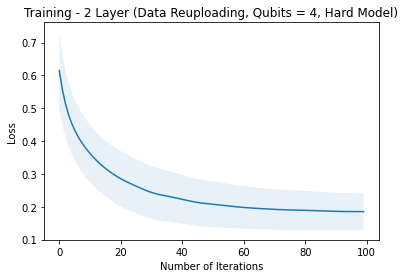

In [6]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 2 Layer (Data Reuploading, Qubits = 4, Hard Model)")

In [7]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Layer2Easy4q/quantum_loss_easy_layer24q_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

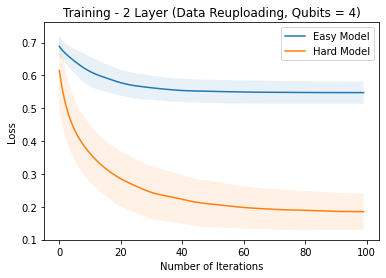

In [8]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 2 Layer (Data Reuploading, Qubits = 4)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)